In [2]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import KFold, cross_val_score

In [4]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Обработка данных

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [ ]:
train_df.describe()

,amount,post_code,lat,lon,population_city,merchant_lat,merchant_lon,target
count,786431.000000,786431.000000,786431.000000,786431.000000,7.864310e+05,786431.000000,786431.000000,786431.000000
mean,70.241296,48802.521336,38.527972,-90.224069,8.928853e+04,38.527301,-90.224508,0.005727
std,161.091489,26896.564152,5.078756,13.754760,3.028600e+05,5.113222,13.766977,0.075461
min,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,19.027804,-166.670132,0.000000
25%,9.650000,26237.000000,34.620500,-96.798000,7.430000e+02,34.727480,-96.901593,0.000000
50%,47.410000,48174.000000,39.346500,-87.476900,2.456000e+03,39.357665,-87.436919,0.000000
75%,83.000000,72042.000000,41.894800,-80.158000,2.047800e+04,41.950609,-80.233429,0.000000
max,27390.120000,99783.000000,66.693300,-67.950300,2.906700e+06,67.441518,-66.955996,1.000000


Преобразуем время транзакции в datetime и разделим на год, месяц, день, час, день недели. Для широты и долготы применим преобразование в декартовы координаты на сфере.

In [5]:
train_df.transaction_time = pd.to_datetime(train_df.transaction_time)

In [6]:
train_df['year'] = train_df.transaction_time.dt.year
train_df['month'] = train_df.transaction_time.dt.month
train_df['day'] = train_df.transaction_time.dt.day
train_df['hour'] = train_df.transaction_time.dt.hour
train_df['weekday'] = train_df.transaction_time.dt.weekday

In [7]:
def toCartesian(lat, lon):
    R = 6378  #радиус земли
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
    z = R * np.sin(np.radians(lat))
    return x, y, z

train_df['x'], train_df['y'], train_df['z'] =  toCartesian(train_df.lat, train_df.lon)

train_df['x_m'], train_df['y_m'], train_df['z_m'] =  toCartesian(train_df.merchant_lat, train_df.merchant_lon)

In [8]:
test_df.transaction_time = pd.to_datetime(test_df.transaction_time)

test_df['year'] = test_df.transaction_time.dt.year
test_df['month'] = test_df.transaction_time.dt.month
test_df['day'] = test_df.transaction_time.dt.day
test_df['hour'] = test_df.transaction_time.dt.hour
test_df['weekday'] = test_df.transaction_time.dt.weekday

test_df['x'], test_df['y'], test_df['z'] =  toCartesian(test_df.lat, test_df.lon)

test_df['x_m'], test_df['y_m'], test_df['z_m'] =  toCartesian(test_df.merchant_lat, test_df.merchant_lon)

Для кодирования категориальных признаков объединим данные в один датасет и применим Label Encoding

In [ ]:
unique_counts = train_df.nunique().reset_index()
unique_counts.columns = ['Column', 'Unique Values']
unique_counts

,Column,Unique Values
0,transaction_time,419851
1,merch,693
2,cat_id,14
3,amount,43385
4,name_1,348
5,name_2,479
6,gender,2
7,street,965
8,one_city,879
9,us_state,51


In [9]:
combined_df = pd.concat([train_df, test_df], axis=0)

In [10]:
cat_cols = ['merch', 'cat_id', 'name_1', 'name_2',
       'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs']

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_df = combined_df[cat_cols].copy()


for col in cat_cols:
    cat_df[col] = le.fit_transform(combined_df[col])

In [ ]:
# съедает ОЗУ даже в колабе ((
# new_cols_dummies = pd.get_dummies(train_df[cat_cols], dtype=int, drop_first=True)

Преобразуем обратно в тестовый и тренировочный датасеты

In [12]:
cat_train_encoded = cat_df.iloc[:len(train_df)]
cat_test_encoded = cat_df.iloc[len(train_df):]

cat_train_encoded.index = train_df.index
cat_test_encoded.index = test_df.index

In [13]:
trainNumeric = train_df.drop(columns= cat_cols).drop(columns= ['transaction_time', 'lat', 'lon', 'merchant_lat', 'merchant_lon', 'target'])

trainEncoded = trainNumeric.merge(cat_train_encoded, left_index=True, right_index=True)

In [14]:
testNumeric = test_df.drop(columns= cat_cols).drop(columns= ['transaction_time', 'lat', 'lon', 'merchant_lat', 'merchant_lon'])
testEncoded = testNumeric.merge(cat_test_encoded, left_index=True, right_index=True)

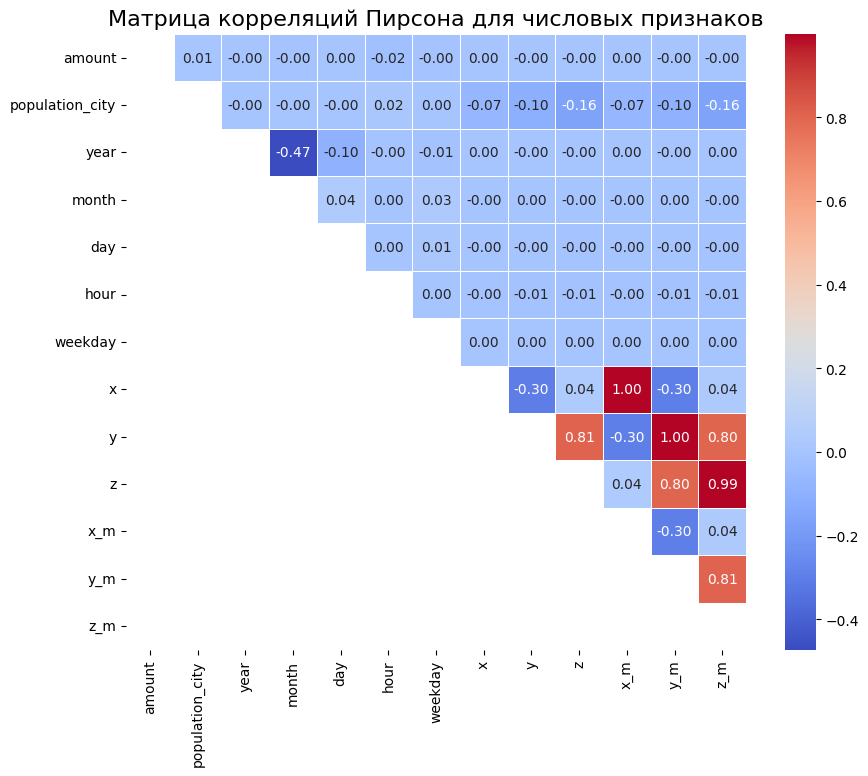

In [ ]:
data = trainNumeric

corr = data.corr('pearson')


mask = np.tril(np.ones_like(corr, dtype=bool))  # маска для нижней части матрицы, чтобы не дублировать отображение для пар признаков
corr_tri = corr.mask(mask)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_tri, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Матрица корреляций Пирсона для числовых признаков', fontsize=16)
plt.show()

Координаты продавца и покупателя сильно скоррелированы - как правило, покупки совершаются в одном месте

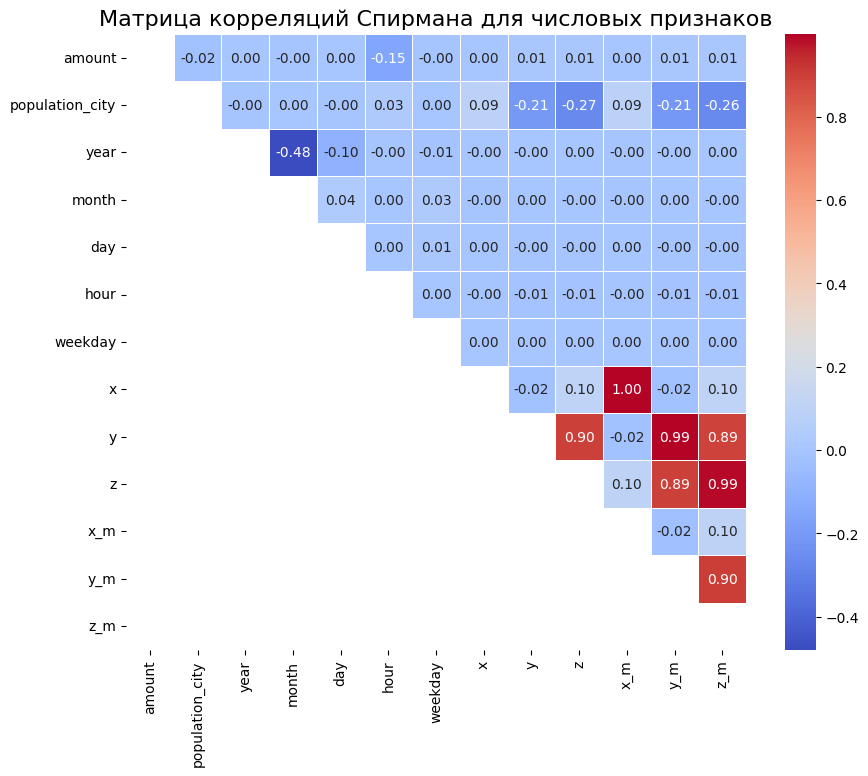

In [ ]:
data = trainNumeric

corr = data.corr('spearman')


mask = np.tril(np.ones_like(corr, dtype=bool))  # маска для нижней части матрицы, чтобы не дублировать отображение для пар признаков
corr_tri = corr.mask(mask)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_tri, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Матрица корреляций Спирмана для числовых признаков', fontsize=16)
plt.show()

In [15]:
trainEncoded.head()

,amount,population_city,year,month,day,hour,weekday,x,y,z,...,merch,cat_id,name_1,name_2,gender,street,one_city,us_state,post_code,jobs
0,148.04,60,2019,12,27,15,4,-2296.768655,-3873.602905,4516.518380,...,105,5,90,260,1,829,397,37,920,301
1,39.40,1412,2019,4,17,23,2,286.069867,-5364.483428,3437.930421,...,80,5,133,465,0,287,636,1,360,136
2,52.96,1831,2019,9,23,15,0,665.274490,-4849.068918,4089.355020,...,537,7,207,326,1,739,531,35,429,45
3,7.66,43,2019,5,13,16,0,-480.415437,-5423.679906,3321.412544,...,406,5,248,259,0,670,665,43,766,171
4,51.59,1725,2019,8,18,7,6,-2496.879561,-4215.189694,4083.705706,...,399,2,72,217,0,789,75,4,914,69


In [16]:
X = trainEncoded
y = train_df.target

In [ ]:
X.head()

,amount,population_city,year,month,day,hour,weekday,x,y,z,...,merch,cat_id,name_1,name_2,gender,street,one_city,us_state,post_code,jobs
0,148.04,60,2019,12,27,15,4,-2296.768655,-3873.602905,4516.518380,...,105,5,90,260,1,829,397,37,920,301
1,39.40,1412,2019,4,17,23,2,286.069867,-5364.483428,3437.930421,...,80,5,133,465,0,287,636,1,360,136
2,52.96,1831,2019,9,23,15,0,665.274490,-4849.068918,4089.355020,...,537,7,207,326,1,739,531,35,429,45
3,7.66,43,2019,5,13,16,0,-480.415437,-5423.679906,3321.412544,...,406,5,248,259,0,670,665,43,766,171
4,51.59,1725,2019,8,18,7,6,-2496.879561,-4215.189694,4083.705706,...,399,2,72,217,0,789,75,4,914,69


<Axes: xlabel='target', ylabel='count'>

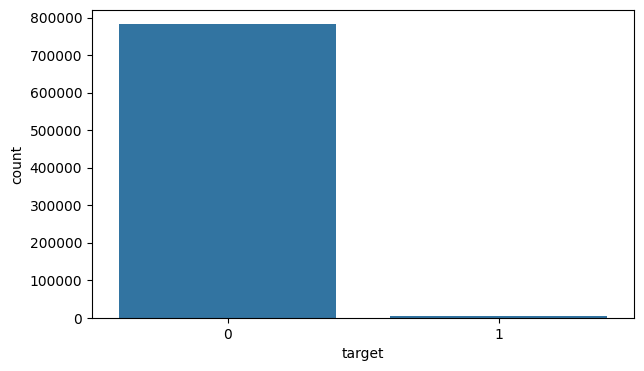

In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.countplot(train_df, x= 'target')

В наборе выраженный дисбаланс классов. Варианты модели на стратифицированной выборке давали очень плохой скор на валидации, поэтому применен SMOTE для увеличения миноритарного класса - метод для сбалансированного увеличения числа наблюдений.

In [17]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
x_smote, y_smote = smote.fit_resample(X, y)

print("Размер x_smote:", x_smote.shape)
print("Размер y_smote:", y_smote.shape)
print("Распределение классов после SMOTE:\n", pd.Series(y_smote).value_counts())

Размер x_smote: (1172890, 23)
Размер y_smote: (1172890,)
Распределение классов после SMOTE:
 target
0    781927
1    390963
Name: count, dtype: int64


Далее выборка разбита уже на SMOTE данных

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    x_smote,
    y_smote,
    test_size=0.3,
    stratify=y_smote,  # Сохраняем баланс классов
    random_state=42
)

Один из вариантов с высоким скором на валидации, но низким на тестовом наборе - XGBClassifier. Эту модель не удалось доработать, поэтому применен ряд других классификаторов.

In [ ]:
bst = XGBClassifier(n_estimators=300, learning_rate=0.04)
# fit model
bst.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

[0]	validation_0-logloss:0.60888
[100]	validation_0-logloss:0.16729
[200]	validation_0-logloss:0.12515
[299]	validation_0-logloss:0.10315


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = bst.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f'F1-Score on test set: {f1}')

F1-Score on test set: 0.941640636390547


# Финальная модель

## Интро

1) Для обработки категориальных данных применен Label Encoding, так как One Hot Encoding создавал слишком большое число признаков с малым "вкладом" каждого из признаков. Широта и долгота были преобразованы в декартовы координаты (x, y, z) в трехмерном пространстве, где Земля представлена как сфера с радиусом R = 6378 км. Колонка с датами была преобразована на отдельные колонки с указанием на год, месяц, день, час, день недели.

2) Выбран алгоритм RandomForestClassifier, так как на валидации и тестовых данных были получены более высокие метрики и более стабильные результаты. Эта модель подходит для больших объемов данных, однако склонна к переобучению, что видно на финальном скоре модели на лидерборде (около 0.7) и рассчитанном на валидации(практически 0.99).

3) Алгоритм обладает устойчивостью к шуму и выбросам и позволяет оценивать важность признаков, после применения SMOTE показывает хорошо интерпретируемые результаты и не требует тщательной предобработки. Тем не менее, это достаточно простой алгоритм и он не "улавливает" все связи в данных, что видно по итоговому скору

4) Валидация проводилась на стратифицированной тестовой выборке после увеличения минорного класса методом SMOTE

In [ ]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train)
rf_pred = rfModel.predict(X_test)

In [ ]:
print(f"Random forest: {f1_score(y_test, rf_pred) : 10.4f}")

Random forest:     0.9965


In [ ]:
importances = rfModel.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

print("Важность признаков:")
for f_idx, idx in enumerate(indices):
    print(f"{f_idx + 1}. {feature_names[idx]}: {importances[idx]:.4f}")

Важность признаков:
1. amount: 0.5518
2. cat_id: 0.0748
3. hour: 0.0583
4. day: 0.0222
5. weekday: 0.0213
6. population_city: 0.0202
7. merch: 0.0196
8. month: 0.0193
9. street: 0.0181
10. x_m: 0.0175
11. jobs: 0.0175
12. one_city: 0.0174
13. name_2: 0.0174
14. name_1: 0.0165
15. z: 0.0155
16. post_code: 0.0151
17. x: 0.0151
18. z_m: 0.0151
19. y_m: 0.0150
20. y: 0.0147
21. us_state: 0.0104
22. gender: 0.0045
23. year: 0.0027


### 2 вариант модели: попытка прменить RandomizedSearchCV

In [ ]:
params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, None],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}, None],
    'bootstrap': [True, False],
    'ccp_alpha': [0, 0.01, 0.1]
}

base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
scorer = make_scorer(f1_score, average='binary')

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params,
    n_iter=100,
    cv=[(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test)))],
    scoring=scorer,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(np.vstack([X_train, X_test]), np.concatenate([y_train, y_test]))

print("Лучшие параметры:", search.best_params_)
print("Лучший F1-score:", search.best_score_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


Потребовалось слишком много времени на подбор параметров таким способом, в том числе из-за выбранного большого разброса в параметрах. Финальный результат так и не был получен.

### 3 вариант модели

Также применялся метод главных компонент для уменьшения размерности, однако модель сильно переобучилась и представила плохой скор на тесте.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X_train)
X_train_scaled_pca = pca.transform(X_train)
X_val_scaled_pca = pca.transform(X_test)

X_test_scaled_pca = pca.transform(testEncoded)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
rfc.score(X_val_scaled_pca, y_test)

0.9947565415341593

#**Outro**

1) Необходим более глубокий статистический анализ связей между признаками, поиск значимости каждого признака. По результатам поиска feature_importances были определены менее значимые признаки - штат, пол и год, необходимо рассмотреть спецификации модели без малозначимых признаков с предварительной оценкой кумулятивного вклада. Возможно построение линейной регрессии для оценки связи между факторами и целевой переменной и расчет уровня значимости для коэффициентов.

2) Подбор гиперпараметров оказался слишком долгим для выбранной модели и данных, сгенерированных SMOTE. Результаты модели на валидации и тесте говорят о переобучении и плохой способности находить различия между классами: можно предположить, что в низкий F-score на тестовых данных вклад вносит именно смещение в сторону мажоритарного класса, несмотря на применение SMOTE. Таким образом, выбранная модель неоптимальна. Необходимо применение ансамбля моделей или более сложных моделей после очистки данных от малозначимых признаков: например, LGBM или CatboostClassifier, вторая может быть более эффективна из-за функции обработки категориальных признаков.

3) Также практически не проводиолся Feature Engineering. Необходимы другие способы обработки первичных данных: например, использование координат в изначальном виде и поиск связей между данными.


Anastasia Bromberg, 42

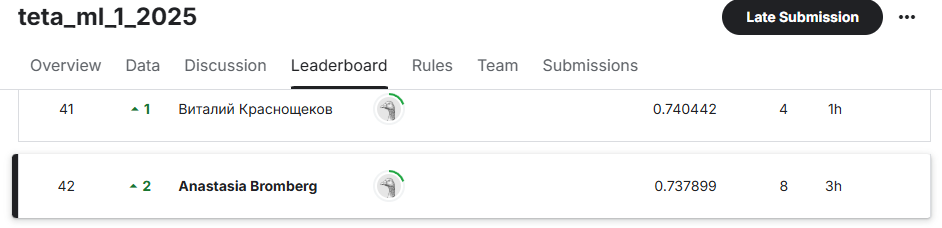